<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/w2d3_t1_initial/W2D3_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy: Week 2, Day 3, Tutorial 1
# Modern RNNs

__Content creators:__ James Evans, Bhargav Srinivasa Desikan, Anis Zahedifard

__Content reviewers:__ XXXXX, XXXXXX

__Content editors:__ XXXXX

__Production editors:__ Roberto Guidotti, Spiros Chavlis, XXXXXX




----
# Tutorial objectives

Before we begin with exploring how RNNs excel at modelling sequences, we will explore some of the other ways we can model sequences, encode text, and make meaningful measurements using such encodings and embeddings. 

---
## Setup

In [ ]:
# @title Imports
# imports
 
!pip install --upgrade gensim --quiet
!pip install torchtext==0.4.0 --quiet
!pip install unidecode --quiet
!pip install d2l --quiet
 
import re
import os
import sys
import math
import time
import nltk
import torch
import random
import string
import unidecode
import collections
import glob

import numpy as np
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

 
from gensim.models import Word2Vec
from nltk.corpus import brown
from sklearn.manifold import TSNE
from torch.autograd import Variable
from torchtext import data, datasets
from torchtext.vocab import Vectors
 
from IPython.display import Image, YouTubeVideo
from torch.nn import functional as F
from d2l import torch as d2l
 
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')
nltk.download('webtext')
 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# @title Seed
# imports

seed = 522
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [ ]:
# @title Figure Settings
import ipywidgets as widgets
%matplotlib inline 
fig_w, fig_h = (8, 6)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})
%config InlineBackend.figure_format = 'retina'
SMALL_SIZE = 12

plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/"
              "course-content/master/nma.mplstyle")

# plt.rcParams.update(plt.rcParamsDefault)
# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title

---
# Section 1: Sequences, Markov Chains & HMMs


In this notebook we will be exploring the world of sequences - thinking of what kind of data can be thought of as sequences, and how these sequences can be represented as Markov Chains and Hidden Markov Models. These ideas and methods were an important part of natural language processing and language modelling, and serve as a useful way to ground ourselves before we dive into neural network methods.

## Section 1.1: What data are sequences?

Native Sequences:

- Temporally occurring events (e.g., history, stock prices)
- Temporally processed events (e.g., communication)
- Topologically connected components (e.g., polymers, peptides)

Synthetic Sequences: 

- Anything processed as a sequence (e.g., scanned pixels in an image)

Sequences can be represented as a Markov Process, since this notion of sequential data is intrinsically linked to RNNs, it is a good place for us to start, and natural language (text!) will be our sequence of choice. 

We will be using the Brown corpus which comes loaded with NLTK, and using the entire corpus - this requires a lot of RAM for some of the methods, so we recommend using a smaller subset of categories if you do not have enough RAM.

We will be using some of the code from this [tutorial](https://www.kdnuggets.com/2019/11/markov-chains-train-text-generation.html) and this [Jupyter notebook](https://github.com/StrikingLoo/ASOIAF-Markov/blob/master/ASOIAF.ipynb).

In [ ]:
category = ['editorial', 'fiction', 'government', 'news', 'religion']
sentences = brown.sents(categories=category) 

Now that we have our sentences, let us look at some statistics to get an idea of what we are dealing with.

In [ ]:
lengths = [len(sentence) for sentence in sentences]
lengths = pd.Series(lengths)

In [ ]:
lengths.quantile(.8)

In [ ]:
lengths.describe()
# 14228 our of 18k

In [ ]:
sentences[0:5]

Since we will be modelling words as sequences in sentences, let us first collect all the words in our corpus.

In [ ]:
corpus_words = []
for sentence in sentences:
  for word in sentence:
    if "''" not in word and "``" not in word:
      corpus_words.append(word)

In [ ]:
print("Corpus length: "+ str(len(corpus_words)))

In [ ]:
corpus_words[0:40]

We'll now get distinct words and create a matrix to represent all these words - this is necessary because we will be using this matrix to look at the probability of the words in sequences.

In [ ]:
distinct_words = list(set(corpus_words))
word_idx_dict = {word: i for i, word in enumerate(distinct_words)}
distinct_words_count = len(list(set(corpus_words)))

In [ ]:
print("Number of distinct words: " + str(distinct_words_count))

In [ ]:
next_word_matrix = np.zeros([distinct_words_count, distinct_words_count])

In [ ]:
word_idx_dict

In the following lines of code we are populating the matrix that tracks the next word in a sentence.

In [ ]:
for i, word in enumerate(corpus_words[:-1]):
    first_word_idx = word_idx_dict[word]
    next_word_idx = word_idx_dict[corpus_words[i+1]]
    next_word_matrix[first_word_idx][next_word_idx] +=1

## Section 1.2: What is a Markov Chain or Model?

A Markov Chain (or Model) is a:
- stochastic model describing a sequence of possible events
- the probability of each event depends only on the state attained in the previous event.
- a countably infinite sequence, in which the chain moves state at discrete time steps, gives a discrete-time Markov chain (DTMC) [vs. a continuous-time process or CTMC].
- The classic formal language model is a Markov Model

*Helpful explanations from [eric mjl's tutorial](https://ericmjl.github.io/essays-on-data-science/machine-learning/markov-models/#non-autoregressive-homoskedastic-emissions)*!



The simplest Markov models assume that we have a _system_ that contains a finite set of states,
and that the _system_ transitions between these states with some probability at each time step $t$,
thus generating a sequence of states over time.
Let's call these states $S$, where

$$S = \{s_1, s_2, ..., s_n\}$$

To keep things simple, let's start with three states:

$$S = \{s_1, s_2, s_3\}$$

A Markov model generates a sequence of states, with one possible realization being:

$$\{s_1, s_1, s_1, s_3, s_3, s_3, s_2, s_2, s_3, s_3, s_3, s_3, s_1, ...\}$$

And generically, we represent it as a sequence of states $x_t, x_{t+1}... x_{t+n}$. (We have chosen a different symbol to not confuse the "generic" state with the specific realization. Graphically, a plain and simple Markov model looks like the following:




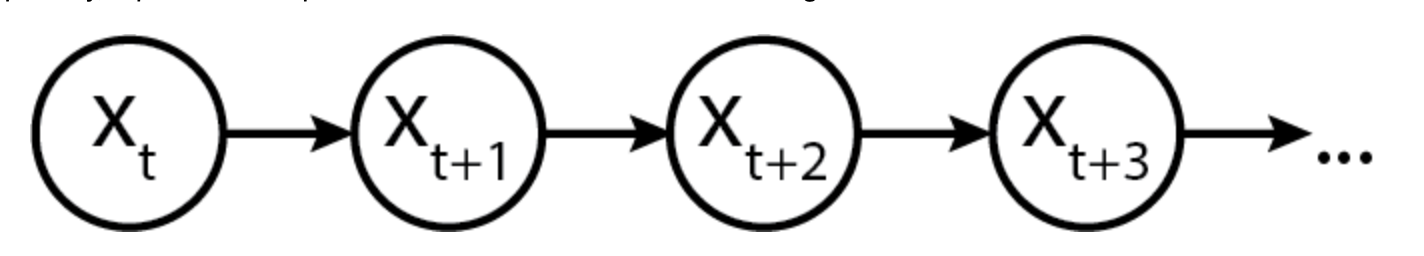

### Modelling transitions between states

To know how a system transitions between states, we now need a **transition matrix**.
The transition matrix describes the probability of transitioning from one state to another.
(The probability of staying in the same state is semantically equivalent to transitioning to the same state.) 

By convention, transition matrix rows correspond to the state at time $t$,
while columns correspond to state at time $t+1$.
Hence, row probabilities sum to one,
because the probability of transitioning to the next state depends on only the current state,
and all possible states are known and enumerated.

Let's call the transition matrix $P_{transition}$.
The symbol etymology, which usually gets swept under the rug in mathematically-oriented papers, are as follows: 

- $transition$ doesn't refer to time but simply indicates that it is for transitioning states, 
- $P$ is used because it is a probability matrix.

$$ P_{transition} = 
\begin{pmatrix}
    p_{11} & p_{12} & p_{13}\\
    p_{21} & p_{22} & p_{23}\\
    p_{31} & p_{32} & p_{33}\\
\end{pmatrix}
$$

Using the transition matrix, we can express that the system likes to stay in the state that it enters into,
by assigning larger probability mass to the diagonals.
Alternatively, we can express that the system likes to transition out of states that it enters into,
by assigning larger probability mass to the off-diagonal.

In our case, this matrix is created by seeing which words appear after each other.

In [ ]:
def most_likely_word_after(aWord):
    most_likely = next_word_matrix[word_idx_dict[aWord]].argmax()
    return distinct_words[most_likely]

Using our most likely word function, we can begin to create chains of words and create sequences. In the code below we create a naive chain that simply choses the most likely word.

In [ ]:
def naive_chain(seed, length=15):
    current_word = seed
    sentence = seed

    for _ in range(length):
        sentence+=' '
        next_word = most_likely_word_after(current_word)
        sentence+=next_word
        current_word = next_word
    return sentence

In [ ]:
print(naive_chain('the'))
print(naive_chain('I'))
print(naive_chain('he'))
print(naive_chain('she'))

We can now be a little more sophisticated, and return words in a sequence using a weighted choice.

In [ ]:
from random import random 

def weighted_choice(objects, weights):
    """ returns randomly an element from the sequence of 'objects', 
        the likelihood of the objects is weighted according 
        to the sequence of 'weights', i.e. percentages."""

    weights = np.array(weights, dtype=np.float64)
    sum_of_weights = weights.sum()
    # standardization:
    np.multiply(weights, 1 / sum_of_weights, weights)
    weights = weights.cumsum()
    x = random()
    for i in range(len(weights)):
        if x < weights[i]:
            return objects[i]

In [ ]:
from numpy.random import choice

def sample_next_word_after(word, alpha=0):
    next_word_vector = next_word_matrix[word_idx_dict[word]] + alpha
    likelihoods = next_word_vector/next_word_vector.sum()
    return weighted_choice(distinct_words, likelihoods)

In [ ]:
sample_next_word_after('the')

In [ ]:
def stochastic_chain(seed, length=15):
    current_word = seed
    sentence = seed

    for _ in range(length):
        sentence+=' '
        next_word = sample_next_word_after(current_word)
        sentence+=next_word
        current_word = next_word
        
    return sentence

In [ ]:
stochastic_chain('Hospital')

Neat - we can create stochastic chains for a single word. For a more effective language model, we would want to model sets of words - in the following cells, we create sets of words to predict a chain after a sequence.

In [ ]:
k = 3
sets_of_k_words = [ ' '.join(corpus_words[i:i+k]) for i, _ in enumerate(corpus_words[:-k]) ]

print([len(list(set(sets_of_k_words))),
       len(sets_of_k_words)])

In [ ]:
from scipy.sparse import dok_matrix

sets_count = len(list(set(sets_of_k_words)))
next_after_k_words_matrix = dok_matrix((sets_count, len(distinct_words)))
print(next_after_k_words_matrix.shape)

In [ ]:
distinct_sets_of_k_words = list(set(sets_of_k_words))
k_words_idx_dict = {word: i for i, word in enumerate(distinct_sets_of_k_words)}
distinct_k_words_count = len(list(set(sets_of_k_words)))
print(len(sets_of_k_words))

In [ ]:
for i, word in enumerate(sets_of_k_words[:-k]):
    if i % 50000 == 0:
        print(i)
    word_sequence_idx = k_words_idx_dict[word]
    next_word_idx = word_idx_dict[corpus_words[i+k]]
    next_after_k_words_matrix[word_sequence_idx, next_word_idx] += 1

In [ ]:
def stochastic_chain(seed, chain_length=15, seed_length=2):
    current_words = seed.split(' ')
    if len(current_words) != seed_length:
        raise ValueError(f'wrong number of words, expected {seed_length}')
    sentence = seed

    for _ in range(chain_length):
        sentence+=' '
        next_word = sample_next_word_after_sequence(' '.join(current_words))
        sentence+=next_word
        current_words = current_words[1:]+[next_word]
    return sentence

In [ ]:
from numpy.random import choice

def sample_next_word_after_sequence(word_sequence, alpha = 0):
    next_word_vector = next_after_k_words_matrix[k_words_idx_dict[word_sequence]] + alpha
    likelihoods = next_word_vector/next_word_vector.sum()
    return weighted_choice(distinct_words, likelihoods.toarray())

In [ ]:
k_words_idx_dict

In [ ]:
stochastic_chain('in The Story', seed_length=3)

In [ ]:
distinct_sets_of_k_words[:10]



## Section 1.3: What is a Hidden Markov Model?

A 1960s advance (by Leonard Baum and colleagues): Hidden Markov Models are:
- a Markov model in which the system modeled is assumed to be a Markov process/chain with unobservable ("hidden") states. 
- HMM assumes there is another surrogate process whose behavior "depends" on the state--you learn about the state by observing the surrogate process. 
- HMMs have successfully been applied in fields where the goal is to recover a data sequence not immediately observable (but other data that depend on the sequence are).
- The first dominant application: Speech and text processing (1970s)

In this sub-section we will use the python library [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/tutorial.html#training-hmm-parameters-and-inferring-the-hidden-states), which is part of the *scikit-learn* ecosystem. [nlg-with-hmmlearn](https://github.com/mfilej/nlg-with-hmmlearn) offers useful code snippets to adapt ```hmmlearn``` for text data. Because we are using a package that offers many out of the box implementations for HMMs, we don't have to worry about the states, transition matrices, 

In [ ]:
!pip install hmmlearn --quiet

In [ ]:
from sklearn.externals import joblib
from sklearn.preprocessing import LabelEncoder
from hmmlearn import hmm
from nltk import FreqDist

In [ ]:
sentences = brown.sents(categories=category)
words = [word.lower() for sentence in sentences for word in sentence]
lengths = [len(sentence) for sentence in sentences]
alphabet = set(words)

In [ ]:
le = LabelEncoder()
_ = le.fit(list(alphabet))

In [ ]:
seq = le.transform(words)
features = np.fromiter(seq, np.int64)
features = np.atleast_2d(features).T
fd = FreqDist(seq)

Now that we have our data setup, we can create our model. We use a multinomial HMM with 8 states, and can either do a random initialisation or use word frequences. We recommend trying both options!

In [ ]:
def get_model(num_states):
    print("Initial parameter estimation using built-in method")
    model = hmm.MultinomialHMM(n_components=num_states, init_params='ste')
    return model


In [ ]:
### Note: It seems that it is not used !
def frequencies(num_states):
    print("Initial parameter estimation using relative frequencies")

    frequencies = np.fromiter((fd.freq(i) for i in range(len(alphabet))), dtype=np.float64)
    emission_prob = np.stack([frequencies]*num_states)

    model = hmm.MultinomialHMM(n_components=num_states, init_params='st')
    model.emissionprob_ = emission_prob
    return model

In [ ]:
num_states = 8
model = get_model(num_states)
model = model.fit(features, lengths)

In [ ]:
num_lines = 5
for _i in range(num_lines):
    random_len = 15
    seed = seed + 1

    symbols, _states = model.sample(random_len)

    output = le.inverse_transform(np.squeeze(symbols))
    for word in output:
        print(word, end=" ")
    print()

### Useful links for Markov Models and HMM:

[Markov Chain Text](https://towardsdatascience.com/simulating-text-with-markov-chains-in-python-1a27e6d13fc6)

[Python QuantEcon: Finite Markov Chains with Finance](https://python.quantecon.org/finite_markov.html)

[Markov Models from the ground up, with python](https://ericmjl.github.io/essays-on-data-science/machine-learning/markov-models/)

[GenTex](https://github.com/nareshkumar66675/GenTex)

[HMM learn](https://hmmlearn.readthedocs.io/en/latest/tutorial.html)

## Exercise 1 

***Note: Don't know where to put it***

We have seen how we can use sequences of text to form probability chains, as well as how we can use out of the box models to generate text. In this exercise, you will be using your own data to generate sequences using hmmlearn. Explore the transition probabilities in your corpus and generate sentences.

---
# Section 2: Encoding Text


## Section 2.1: Text Data - Cleaning, Organising, and Representing

This section will cover basic code and key concepts for textual data cleaning, organising and representing. We often describe this part of dealing with data as pre-processing. We also note that it is often encouraged to perform less pre-processing with deep learning methods and more data (e.g., stem with small data and non-neural methods; do not stem with big data and neural methods.) At the limits, with extremely large data and very deep models, we may actually add noise to the data to increase the robustness of our models to errors and outliers.

In [ ]:
# @title Imports
import numpy as np
import matplotlib.pyplot as plt

# no critical warnings, so we supress it
import warnings
warnings.simplefilter("ignore")

In [ ]:
# @title Text related packages
import gensim
import spacy
from gensim.corpora import Dictionary
from gensim.models import LdaModel

In [ ]:
# @title ML and DL packages
import sklearn
import keras

Let's whip up some trivial texts so that we can illustrate the creation of different representations. We will construct our raw texts such that there are a few overlapping words. Note that there are 4 sentences, and each sentence is the complete document or text.

In [ ]:
raw_texts = ["Apples taste like onions when we cannot smell.",
             "I find it easy to compare apples and oranges.",
             "Chopping onions can make you cry.",
             "Peeling an orange does not make you cry."]

We now load an English [spaCy language model](https://spacy.io/usage/models), which allows us to do a number of basic linguistic and textual analysis.

In [ ]:
nlp = spacy.load('en')

Our first use of the language model is to clean the data - when we pass text through the language model, it [tokenises](https://nlp.stanford.edu/IR-book/html/htmledition/tokenization-1.html) it, and assigns various attributes, such as whether or not it is a [stop word](https://nlp.stanford.edu/IR-book/html/htmledition/dropping-common-terms-stop-words-1.html), number, and its part of speech. A stop word is a word we deem irrelevant or will distract from or diminish our analysis - some examples are articles (a, an, the), filler words, and so on. You will notice that here we also used a [lemmatised](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html) form of the word, which is a way of extracting the linguistic 'root' of the word. Again, the more plentiful your data and deeper your model (e.g., BERT), the less likely you should be to remove, prune and process text data because the model is designed to do it for you. Even then, however, sometimes augmenting data with these representations can accelerate model training and performance. 

In [ ]:
texts, article = [], []
for text in raw_texts:
    doc = nlp(text)
    article = []
    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article!
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num:
            # we add the lematized version of the word
            article.append(w.lemma_)

    texts.append(article)

Let's see what that did to our texts.

In [ ]:
print(texts)

We see that from a list of strings we now have a list of lists, and each of these lists is a list of strings (words, or tokens). You can see that punctuation and stop words are removed and it is now closer to machine-readable and analysis-ready. This process of going from raw, punctuated text to individual tokens is called tokenization.

Now, we use the gensim dictionary class to map each of these words to an ID and represent them as a bag of words.

In [ ]:
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [ ]:
print(corpus)

We see here that each sentence is represented by a word ID and the number of times it was present in that document. We now look at Term Frequency - Inverse Document Frequency ([TF-IDF](https://nlp.stanford.edu/IR-book/html/htmledition/tf-idf-weighting-1.html)), one simple way to measure word importance (locally and globally). Such representations begin to build representations that begin to approximate some of the things automatically learned within a deep model. Sometimes these representations can be fed into a deep model as input (augmented data).

In [ ]:
from gensim.models import TfidfModel

tf_idf_model = TfidfModel(corpus)
tf_idf_texts = tf_idf_model[corpus]

In [ ]:
tf_idf_texts[0]

In [ ]:
tf_idf_texts[1]

We now see each document is a word ID mapped to a number that measures how it distinguishes the document.

### One Hot Encoding and Vectorising with scikit-learn

So we saw how we can go from raw, punctuated texts to cleaner texts my manually picking out what we want. The bag of words format tells us which words exist, but the vector length isn't standard, and you can see the same for TF-IDF. There are ways to present this information in what is called a 1-hot vector, where the length of the vector is the whole vocabulary. 

It can be useful to use gensim and spaCy for pre-processing because it is more clear at each step what my data structure looks like. However, for an abstracted approach to text pre-processing, scikit-learn works well, especially when you want to feed it into a traditional machine learning algorithm. Gensim, for example, would convert bag of words or tf-idf into a similar data structure under the hood to keep the lengths of the vector the same. 

See below for code to use the scikit-learn vectoriser, which creates both one hot encoding vectors as well as tf-idf vectors which are **sparse representations**. 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline

In [ ]:
 vectorizer = CountVectorizer()
 X = vectorizer.fit_transform(raw_texts).toarray()

In [ ]:
vectorizer.vocabulary_

In [ ]:
raw_texts

In [ ]:
len(X[0]), len(vectorizer.vocabulary_)

You can see that the length of each vector is the length of the full vocavulary. Below, for each document, a 1 is a presence of that word_id (which you can confirm using the dictionary above), and a 0 is the absence of a word. 

In [ ]:
print(X)

Below this we create a similar sparse representation, but using TF-IDF, and remove stop-words using the built-in function.

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(raw_texts).toarray()

In [ ]:
print(X)

We will now be moving on from sparse representations to dense representations of documents, with a range of methods which can be used to condense information in a body of text.

### Low and High Dimensional Representations of Text and Documents

One of the issues with using a bag of words or TF-IDF to represent documents is that even though you’ve reduced the size of the document from the full vocabulary, for documents with a lot of words, they remain very high dimensional objects (e.g., where each dimension is defined by a word in the vocabulary, a long document might have 20,000 dimensions or unique words). LSA stands for latent semantic analysis (sometimes also referred to as LSI, or Latent Semantic Indexing), and is a way to represent text documents by reducing the dimensionality of the word (or meaning)-space represented by a TF-IDF or bag of words. The idea is this: if words in documents are rows and the documents are columns, we want to keep the same distance between columns (documents) while reducing the number of rows (reduced word-features). By representing documents with a reduced number of features instead of using all the words, we now represent each with “latent” features rooted in the idea of distributional semantics--that words appearing together are likely to reference similar meanings.

Let us use `TruncatedSVD` to perform a latent semantic analysis on our data. SVD -- Singular Value Decomposition -- is a form of matrix factorization very similar to Principle Components Analysis (PCA), which we saw last week, but it can be computed on rectangular (not square) datasets. The truncation comes as we limit the number of Singular Values (dimensions) that we consider by selecting the most informative and distinguishing $n$. 

In [ ]:
svd = TruncatedSVD(2)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X = lsa.fit_transform(X)

In [ ]:
print(X)

Each document here is represented by 2 features ($n=2$)!

Now we'll take a quick peak at topic models, word and document embedding methods, and other low dimensional methods that can be used to represent document in meaning space. 

We're going to use a bigger dataset, because these methods are only useful when we have substantial data. Models based on very large datasets take time to train, so we'll use a medium sized corpus that comes pre-loaded with gensim to illustare the concepts.

In [ ]:
import os

test_data_dir = '{}'.format(os.sep).join([gensim.__path__[0], 'test', 'test_data'])
lee_train_file = test_data_dir + os.sep + 'lee_background.cor'
text = open(lee_train_file).read()

In [ ]:
doc = nlp(text.lower())

In [ ]:
my_stop_words = [u'say', u'mr', u'said', u'saying', u'says']
for stopword in my_stop_words:
    lexeme = nlp.vocab[stopword]
    lexeme.is_stop = True

In [ ]:
# we add some words to the stop word list
texts, article = [], []
for w in doc:
    # if it's not a stop word or punctuation mark, add it to our article!
    if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and w.text != 'I':
        # we add the lematized version of the word
        article.append(w.lemma_)
    # if it's a new line, it means we're onto our next document
    if w.text == '\n':
        texts.append(article)
        article = []

In [ ]:
len(texts)

In [ ]:
texts[0][0:10]

### Bi-grams and n-grams
Here we identify statistically significant bigrams (two sequential word units of meaning) that may go into a model as single units.

In [ ]:
bigram = gensim.models.Phrases(texts)
texts = [bigram[line] for line in texts]

In [ ]:
texts[0][0:20]

### Topic Models
Topic models are a two-level clustering technique in which topics are identified as distributions over words, such that documents may be modeled as distributions over topics. 

In [ ]:
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
ldamodel = LdaModel(corpus=corpus, num_topics=5, id2word=dictionary)

In [ ]:
ldamodel.print_topics()

In [ ]:
lda_doc_5 = ldamodel[dictionary.doc2bow(texts[5])]

In [ ]:
lda_doc_5

In [ ]:
texts[5][0:15]

The document on Australian government and asylum is recognized as being composed of a topic with the top words of "Australia", "government", and "people". Now we've seen how both LDA and LSI, in two different packages, and a variety of ways to represent textual documents. Some representations of textual documents can be especially useful for visualising documents - let's try a few of these.

## Section 2.2: Shallow Neural Embeddings

Word2vec, much like methods like LSA which we saw earlier, is based on theories of distributional semantics - words that appear around each other are more likely to mean similar things than words that do not appear around each other. Keeping this in mind, our job is to create a high dimensional space where these semantic relations are preserved. The innovation in word2vec is the realisation that we can use unlabelled, running text in sentences as inputs for a supervised learning algorithm--as a self-supervision task. It is supervised because we use the words in a sentence to serve as positive and negative examples. Let’s break this down:

... "use the kitchen knife to chop the vegetables"…

**C1   C2   C3   T   C4   C5   C6   C7**

Here, the target word is knife, and the context words are the ones in its immediate (6-word) window. 
The first word2vec method we’ll see is called skipgram, where the task is to assign a probability for how likely it is that the context window appears around the target word. In the training process, positive examples are samples of words and their context words, and negative examples are created by sampling from pairs of words that do not appear nearby one another. 

This method of implementing word2vec is called skipgram with negative sampling. So while the algorithm tries to better learn which context words are likely to appear around a target word, it ends up pushing the embedded representations for every word so that they are located optimally (e.g., with minimal semantic distortion). In this process of adjusting embedding values, the algorithm brings semantically similar words close together in the resulting high dimensional space, and dissimilar words far away. 

Another word2vec training method, Continuous Bag of Words (CBOW), works in a similar fashion, and tries to predict the target word, given context. This is converse of skipgram, which tries to predict the context, given the target word. Skip-gram represents rare words and phrases well, often requiring more data for stable representations, while CBOW is several times faster to train than the skip-gram, but with slightly better accuracy for the frequent words in its prediction task. The popular gensim implementation of word2vec has both the methods included. 
 




## Section 2.3: Creating Word Embeddings

We will create embeddings for a subset of categories in [Brown corpus](https://www1.essex.ac.uk/linguistics/external/clmt/w3c/corpus_ling/content/corpora/list/private/brown/brown.html).  In order to achieve this task we will use [gensim](https://radimrehurek.com/gensim/) library to create word2vec embeddings. Gensim’s word2vec expects a sequence of sentences as its input. Each sentence is a list of words.
Calling Word2Vec(sentences, iter=1) will run two passes over the sentences iterator (or, in general iter+1 passes). The first pass collects words and their frequencies to build an internal dictionary tree structure. The second and subsequent passes train the neural model. 
Word2vec accepts several parameters that affect both training speed and quality.

One of them is for pruning the internal dictionary. Words that appear only once or twice in a billion-word corpus are probably uninteresting typos and garbage. In addition, there’s not enough data to make any meaningful training on those words, so it’s best to ignore them:

`model = Word2Vec(sentences, min_count=10)  # default value is 5`


A reasonable value for min_count is between 0-100, depending on the size of your dataset.

Another parameter is the size of the NN layers, which correspond to the “degrees” of freedom the training algorithm has:

`model = Word2Vec(sentences, size=200)  # default value is 100`


Bigger size values require more training data, but can lead to better (more accurate) models. Reasonable values are in the tens to hundreds.

The last of the major parameters (full list [here](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec)) is for training parallelization, to speed up training:

`model = Word2Vec(sentences, workers=4) # default = 1 worker = no parallelization`

In [ ]:
category = ['editorial', 'fiction', 'government', 'mystery', 'news', 'religion',
            'reviews', 'romance', 'science_fiction']

In [ ]:
def create_word2vec_model(category = brown.categories(), size = 50, sg = 1, min_count = 5):
  try:
    sentences = brown.sents(categories=category) 
    model = Word2Vec(sentences, vector_size=size, sg=sg, min_count=min_count)

  except (AttributeError, TypeError):
      raise AssertionError('Input variable "category" should be a string or list,' 
      '"size", "sg", "min_count" should be integers')

  return model

def model_dictionary(model):
  words = list(w2vmodel.wv.key_to_index)
  return words 

def get_embedding(word, model):
  if word in w2vmodel.wv.key_to_index:
    return model.wv[word]
  else:
    return None

In [ ]:
w2vmodel = create_word2vec_model(category)

In [ ]:
print(model_dictionary(w2vmodel))

In [ ]:
print(get_embedding('weather', w2vmodel))

We don't always need to train our own models. One of the advantages of word embedding (and many deep learning) models is using pre-trained models, where the training has already been completed on a large and/or representative corpus or document collection. In the following lines of code we load either a [Google News model](https://drive.google.com/file/d/1TW3h1SIx__4Y6zEzLnrPry2Z-6BZgtyh/view?usp=sharing) (3+ GB), or a [model trained on NY Times data](https://drive.google.com/file/d/1xrs1UhTH5LPTBFLcflX-nQ86zwCAoLt5/view?usp=sharing) (30 MB). If you have Colab Pro, you can try the heavier model. I have used the mounting capacity on google drive here. You can also just upload the file if you prefer.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
model_address = "/content/drive/MyDrive/nytimes_cbow.reduced.txt" 

In [ ]:
nytimes_w2v_model = gensim.models.KeyedVectors.load_word2vec_format(model_address)

In [ ]:
nytimes_w2v_model.most_similar("book")

In [ ]:
nytimes_w2v_model.most_similar("talk")

### Word and Context Embeddings

The gensim model allows us to access both the target embedding for the word itself, and the context embedding for words. These two embedding are multiplied to recreate the original word space, revealing the way in which neural embeddings perform (and are optimized through) matrix factorization of the original word-by-context matrix. The target embedding is what is most commonly used, though in some cases the context is also used along with the target. We show how to use both.

The context vector is not showcased in the documentation - we unearthed it thanks to this helpful [StackOverflow link](https://stackoverflow.com/questions/39406092/how-to-get-both-the-word-embeddings-vector-and-context-vector-of-a-given-word-by).

In [ ]:
book_embedding_ny = nytimes_w2v_model["book"]
book_embedding = w2v_model["book"]

In [ ]:
 book_context_embedding = w2vmodel.wv.syn0[w2vmodel.wv.vocab["book"].index]

In [ ]:
 book_context_embedding_ny = nytimes_w2v_model.wv.syn0[nytimes_w2v_model.wv.vocab["book"].index]

### Exploring Semantics with Embeddings

So what do these vectors encapsulate? We've seen before that it is some notion of meaning, as captured by distributional semantics, with some aspect of syntactic information. How do we then use these word embeddings? Because they capture semantic information in a space that allows for semantic decomposition, a common task is to perform semantic arithmetic and analogy tasks.


Find the word that least matches the others within a word set (cosine similarity).

In [ ]:
nytimes_w2v_model.doesnt_match(['books', 'books', 'novel', 'memoir', 'truck'])

In [ ]:
nytimes_w2v_model.most_similar(positive=['nature', 'science'])

In [ ]:
nytimes_w2v_model.most_similar('cat')

We can also perform arithmetic on vectors using the most_similar function we saw earlier. One of the more popular, earlier examples demonstrating the analogous power of word2vec models was vector['king'] - vector['man'] + vector['woman'] = vector['queen'], where the idea is that we are traversing a "gender" dimension and looking at either end of it. 

Let's see how that works on our NY Times model.

In [ ]:
nytimes_w2v_model.most_similar(positive=['king', 'woman'], negative = ['man'])

If we shift ***king*** in the direction of ***woman***, we get to ***royal***... and almost to ***queen*** (try adding woman twice!) Interestingly, ***prince*** is a similarly effeminate royal. We can begin to see the utility of these models, even if they do capture all semantic associations as we might imagine. Larger language models capture even more sophisticated relationships. 

In the rest of this section we will see other ways in which we can use and explore word embeddings.

## Section 2.4: Visualizing Word Embedding

We can now obtain the word embeddings for any word in the dictionary using word2vec. Let's visualize these embeddings to get an inuition of what these embeddings mean. The word embeddings obtained from word2vec model are in high dimensional space. We will use PCA to pick the 2 features that capture the most variance in the embeddings in order to represent them in a 2D space.


For each word in `keys`, we pick the top 10 similar words (using cosine similarity) and plot them.  

 What should be the arrangement of similar words?
 What should be arrangement of the key clusters with respect to each other?
 

In [ ]:
keys = ['voters', 'magic', 'love', 'God', 'evidence', 'administration', 'governments']

In [ ]:
def get_cluster_embeddings(keys):
  embedding_clusters = []
  word_clusters = []

  # find closest words and add them to cluster
  for word in keys:
      embeddings = []
      words = []
      if not word in w2vmodel.wv.key_to_index:
        print('The word ', word, 'is not in the dictionary')
        continue

      for similar_word, _ in w2vmodel.wv.most_similar(word, topn=10):
          words.append(similar_word)
          embeddings.append(w2vmodel.wv[similar_word])
      embedding_clusters.append(embeddings)
      word_clusters.append(words)

  # get embeddings for the words in clusers
  embedding_clusters = np.array(embedding_clusters)
  n, m, k = embedding_clusters.shape
  tsne_model_en_2d = TSNE(perplexity=10, n_components=2, init='pca', n_iter=3500, random_state=32)
  embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
  return embeddings_en_2d, word_clusters

In [ ]:
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, color=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=10)
    plt.legend(loc="lower left")
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

In [ ]:
embeddings_en_2d, word_clusters = get_cluster_embeddings(keys)
tsne_plot_similar_words('Similar words from Brown Corpus', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')

---
# Section 3: Semantic Measurements
Lecture
Understanding this semantic space: 
(Can do many of the same measurements on sophisticated, BERT-style “spaces”)
Implicit matrix factorization
Conceptually (like Latent Semantic Indexing / Analysis)
Algorithmically through process of optimization
High-D manifold interpretation
Semantic dimensions
Topic decompositions
Alignment 
Over time
Domain
Language
Extensions:
GLoVE (add back some global influence)
FastText (consider character not word sequences)
Tutorial
Semantic dimensions
Shift over time
Vector decomposition (semantic atoms)
Inversion for classification


### Section 3.1: Projecting Embeddings on Dimensions of Social Analysis

We can see how word2vec does remarkably well in capturing certain aspects of semantics! Word embeddings have a lot of utility outside of just looking at relations between words, though. Because words derive their meanings from various social characteristics and dimensions, it is possible for us to project word vectors onto word-defined dimensions to see where they lie. We can create these dimensions by choosing words which that might anchor the dimension and then project other words onto this dimension. For example, if we were trying to find a gender dimension, we might make a vector between the words he, him, man and she, her, woman, and so on. Then, with a cosine projection, we can get a value of where our word of choice might lie on this dimension, revealing to us how “gendered” the word is. The following snippets of code implements this for various such dimensions. Using such a technique for social scientific analysis as described by Kozlowski et al 2019; it can be very easily extended for many business and analytical solutions. 


First we can visualize with dimension reduction

In [ ]:
#words to create dimensions
tnytTargetWords = ['man','him','he', 'woman', 'her', 'she', 
                   'black','blacks','African', 'white', 'whites', 
                   'Caucasian', 'rich', 'richer', 'richest', 'expensive', 
                   'wealthy', 'poor', 'poorer', 'poorest', 'cheap', 'inexpensive']
                   
#words we will be mapping
tnytTargetWords += ["doctor","lawyer","plumber","scientist","hairdresser", 
                    "nanny","carpenter","entrepreneur","musician","writer", 
                    "banker","poet","nurse", "steak", "bacon", "croissant", 
                    "cheesecake", "salad", "cheeseburger", "vegetables", "beer", 
                    "wine", "pastry", "basketball", "baseball", "boxing", "softball", 
                    "volleyball", "tennis", "golf", "hockey", "soccer"]


wordsSubMatrix = []
for word in tnytTargetWords:
    wordsSubMatrix.append(nytimes_model[word])
wordsSubMatrix = np.array(wordsSubMatrix)
#wordsSubMatrix

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pcaWordsNYT = PCA(n_components=50).fit(wordsSubMatrix)
reducedPCA_dataNYT = pcaWordsNYT.transform(wordsSubMatrix)

#T-SNE is theoretically better, but you should experiment
tsneWordsNYT = TSNE(n_components=2).fit_transform(reducedPCA_dataNYT)

In [ ]:
fig = plt.figure(figsize = (20,12))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsNYT[:, 0], tsneWordsNYT[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(tnytTargetWords):
    ax.annotate(word, (tsneWordsNYT[:, 0][i],tsneWordsNYT[:, 1][i]), size =  50 * (len(tnytTargetWords) - i) / len(tnytTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

Define some convenient functions for getting dimensions. 

In [ ]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

Let's calculate three dimensions: gender, race, and class.

In [ ]:
Gender = dimension(nytimes_model, ['man','him','he'], ['woman', 'her', 'she'])
Race = dimension(nytimes_model, ['black','blacks','African'], ['white', 'whites', 'Caucasian'])
Class = dimension(nytimes_model, ['rich', 'richer', 'richest', 'expensive', 'wealthy'], 
                                 ['poor', 'poorer', 'poorest', 'cheap', 'inexpensive'])

Here we have some words.

In [ ]:
Occupations = ["doctor", "lawyer", "plumber", "scientist", "hairdresser", 
               "nanny","carpenter","entrepreneur","musician","writer", 
               "banker","poet","nurse"]

Foods = ["steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", 
         "vegetables", "beer", "wine", "pastry"]

Sports  = ["basketball", "baseball", "boxing", "softball", "volleyball", 
           "tennis", "golf", "hockey", "soccer"]

Define a function to project words in a word list to each of the three dimensions.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def makeDF(model, word_list):
    g = []
    r = []
    c = []
    for word in word_list:
        g.append(cosine_similarity(nytimes_model[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
        r.append(cosine_similarity(nytimes_model[word].reshape(1,-1), Race.reshape(1,-1))[0][0])
        c.append(cosine_similarity(nytimes_model[word].reshape(1,-1), Class.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'gender': g, 'race': r, 'class': c}, index = word_list)
    return df

Get the projections.

In [ ]:
OCCdf = makeDF(nytimes_model, Occupations) 
Fooddf = makeDF(nytimes_model, Foods)
Sportsdf = makeDF(nytimes_model, Sports)

Define some useful functions for plotting.

In [ ]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

Plot the occupational words in each of the three dimensions.

In [ ]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, OCCdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, OCCdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, OCCdf, 'class')
plt.show()

Foods:

In [ ]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Fooddf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Fooddf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Fooddf, 'class')
plt.show()

Sports:

In [ ]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Sportsdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Sportsdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Sportsdf, 'class')
plt.show()

In [ ]:
import argparse
import gzip
import math
import numpy
import re
import sys

from copy import deepcopy

isNumber = re.compile(r'\d+.*')
def norm_word(word):
  if isNumber.search(word.lower()):
    return '---num---'
  elif re.sub(r'\W+', '', word) == '':
    return '---punc---'
  else:
    return word.lower()

''' Read all the word vectors and normalize them '''
def read_word_vecs(filename):
  wordVectors = {}
  if filename.endswith('.gz'): fileObject = gzip.open(filename, 'r')
  else: fileObject = open(filename, 'r')
  
  for line in fileObject:
    line = line.strip().lower()
    word = line.split()[0]
    wordVectors[word] = numpy.zeros(len(line.split())-1, dtype=float)
    for index, vecVal in enumerate(line.split()[1:]):
      wordVectors[word][index] = float(vecVal)
    ''' normalize weight vector '''
    wordVectors[word] /= math.sqrt((wordVectors[word]**2).sum() + 1e-6)
    
  sys.stderr.write("Vectors read from: "+filename+" \n")
  return wordVectors

''' Write word vectors to file '''
def print_word_vecs(wordVectors, outFileName):
  sys.stderr.write('\nWriting down the vectors in '+outFileName+'\n')
  outFile = open(outFileName, 'w')  
  for word, values in wordVectors.iteritems():
    outFile.write(word+' ')
    for val in wordVectors[word]:
      outFile.write('%.4f' %(val)+' ')
    outFile.write('\n')      
  outFile.close()
  
''' Read the PPDB word relations as a dictionary '''
def read_lexicon(filename):
  lexicon = {}
  for line in open(filename, 'r'):
    words = line.lower().strip().split()
    lexicon[norm_word(words[0])] = [norm_word(word) for word in words[1:]]
  return lexicon

''' Retrofit word vectors to a lexicon '''
def retrofit(wordVecs, lexicon, numIters):
  newWordVecs = deepcopy(wordVecs)
  wvVocab = set(newWordVecs.keys())
  loopVocab = wvVocab.intersection(set(lexicon.keys()))
  for it in range(numIters):
    # loop through every node also in ontology (else just use data estimate)
    for word in loopVocab:
      wordNeighbours = set(lexicon[word]).intersection(wvVocab)
      numNeighbours = len(wordNeighbours)
      #no neighbours, pass - use data estimate
      if numNeighbours == 0:
        continue
      # the weight of the data estimate if the number of neighbours
      newVec = numNeighbours * wordVecs[word]
      # loop over neighbours and add to new vector (currently with weight 1)
      for ppWord in wordNeighbours:
        newVec += newWordVecs[ppWord]
      newWordVecs[word] = newVec/(2*numNeighbours)
  return newWordVecs
  
if __name__=='__main__':

  parser = argparse.ArgumentParser()
  parser.add_argument("-i", "--input", type=str, default=None, help="Input word vecs")
  parser.add_argument("-l", "--lexicon", type=str, default=None, help="Lexicon file name")
  parser.add_argument("-o", "--output", type=str, help="Output word vecs")
  parser.add_argument("-n", "--numiter", type=int, default=10, help="Num iterations")
  args = parser.parse_args()

  wordVecs = read_word_vecs(args.input)
  lexicon = read_lexicon(args.lexicon)
  numIter = int(args.numiter)
  outFileName = args.output
  
  ''' Enrich the word vectors using ppdb and print the enriched vectors '''
  print_word_vecs(retrofit(wordVecs, lexicon, numIter), outFileName) 

### Section 3.2: Aligning Word Embeddings

We've explored alignment in some detail in tutorial 2.2, on Data Integration and Alignment. Specifically, we looked at alignment across time and across languages -  in this section, we will revisit these examples.


NOTE: the following section has previously seen code.

#### Time based data

In order to explore this, let's get some data that follows a time trend. We'll look at conference proceedings from the American Society for Clinical Oncologists. You can download the data [here](https://drive.google.com/file/d/1R9EiThdJQ3vY84xcoPJGUBeqvemu_o8L/view?usp=sharing).

In [ ]:
ascoDF = pandas.read_csv("/content/ASCO_abstracts.csv", index_col=0)

In [ ]:
ascoDF['tokenized_sents'] = ascoDF['Body'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])
ascoDF['normalized_sents'] = ascoDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])

In [ ]:
import copy

#### Cross Temporal Alignment

Below is code that aligns the dimensions of multiple embeddings arrayed over time or some other dimension and allow identification of semantic change as the word vectors change their loadings for focal words. This code comes from the approach piloted at Stanford by William Hamilton, Daniel Jurafsky and Jure Lescovec [here](https://arxiv.org/pdf/1605.09096.pdf). 

In this case we train the models ourselves instead of using a pre-trained model, so this might take some time.

In [ ]:
def calc_syn0norm(model):
    """since syn0norm is now depricated"""
    return (model.wv.syn0 / np.sqrt((model.wv.syn0 ** 2).sum(-1))[..., np.newaxis]).astype(np.float32)

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
    (With help from William. Thank you!)
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """
    base_embed = copy.copy(base_embed)
    other_embed = copy.copy(other_embed)
    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    base_vecs = calc_syn0norm(in_base_embed)
    other_vecs = calc_syn0norm(in_other_embed)

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.syn0norm = other_embed.wv.syn0 = (calc_syn0norm(other_embed)).dot(ortho)
    return other_embed
    
def intersection_align_gensim(m1,m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.vocab.keys())
    vocab_m2 = set(m2.wv.vocab.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1&vocab_m2
    if words: common_vocab&=set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count,reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.vocab[w].index for w in common_vocab]
        old_arr = calc_syn0norm(m)
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.syn0norm = m.wv.syn0 = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        old_vocab = m.wv.vocab
        new_vocab = {}
        for new_index,word in enumerate(common_vocab):
            old_vocab_obj=old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.wv.vocab = new_vocab

    return (m1,m2)

In [ ]:
def compareModels(df, category, sort = True):
    """If you are using time as your category sorting is important"""
    embeddings_raw = {}
    cats = sorted(set(df[category]))
    for cat in cats:
        #This can take a while
        print("Embedding {}".format(cat), end = '\r')
        subsetDF = df[df[category] == cat]
        #You might want to change the W2V parameters
        embeddings_raw[cat] = gensim.models.word2vec.Word2Vec(subsetDF['normalized_sents'].sum())
    #These are much quicker
    embeddings_aligned = {}
    for catOuter in cats:
        embeddings_aligned[catOuter] = [embeddings_raw[catOuter]]
        for catInner in cats:
            embeddings_aligned[catOuter].append(smart_procrustes_align_gensim(embeddings_aligned[catOuter][-1], embeddings_raw[catInner]))
    return embeddings_raw, embeddings_aligned

In [ ]:
rawEmbeddings, comparedEmbeddings = compareModels(ascoDF, 'Year')

This is the key to our aligning - the smart procrustes align method here is the one doing the aligning, and we are adding the alligned embeddings to the dictionary. 

We need to compare them across all permutions so we will define another function to help, we will be using 1 - cosine similarity as that gives a more intitive range of 0-2 with low values meaning little change and high meaning lots of change.

In [ ]:
def getDivergenceDF(word, embeddingsDict):
    dists = []
    cats = sorted(set(embeddingsDict.keys()))
    dists = {}
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            dists[cat].append(np.abs(1 - sklearn.metrics.pairwise.cosine_similarity(embeddingsDict[cat][0][word].reshape(1, -1),
                                                                             embed[word].reshape(1, -1))[0,0]))
    return pandas.DataFrame(dists, index = cats)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import seaborn

We now check certain words and see their movement in time along these abstracts.

In [ ]:
targetWord = 'breast'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

In [ ]:
targetWord = 'combination'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

In [ ]:
def findDiverence(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))
    
    dists = []
    for embed in embeddingsDict[cats[0]][1:]:
        dists.append(1 - sklearn.metrics.pairwise.cosine_similarity(embeddingsDict[cats[0]][0][word].reshape(1, -1), embed[word].reshape(1, -1))[0,0])
    return sum(dists)

def findMostDivergent(embeddingsDict):
    words = []
    for embeds in embeddingsDict.values():
        for embed in embeds:
            words += list(embed.wv.vocab.keys())
    words = set(words)
    print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDiverence(w, embeddingsDict)) for w in words], key = lambda x: x[1], reverse=True)
    

In [ ]:
wordDivergences = findMostDivergent(comparedEmbeddings)

In [ ]:
wordDivergences[:20]

In [ ]:
wordDivergences[-20:]

In [ ]:
targetWord = wordDivergences[2][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

In [ ]:
targetWord = wordDivergences[-1][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

We've seen here from a small, research based corpus how it is still able to capture some notion of semantic drift. The word cell has moved among the most and the word view has moved the least. We recommend trying similar analyses on different datasets to see how words change their meaning over time based on the company they keep. 

#### Cross language alignment

While in the previous example we saw how we can use a time-stamped textual corpus to create embeddings and then compare between them, in the following example we use pre-trained embeddings for different languages and align them using some powerful packages.

Here, we use Fast Text word embeddings downloaded from their [documentation website](https://fasttext.cc/), for Spanish and French embeddings. Fast Text does not take the word as a special unit but rather the character window, allowing it to achieve more subtle contextual information. You must download these embeddings and upload them to be able to complete this part of the exercise. Note that these files are large! If it doesn't work, restart your session, clear your uploads and try this section again.

We then perform an SVD and orthogonal transformation on the data to rotate and reflect it so that it best aligns. 
The code is adapted from:
https://github.com/babylonhealth/fastText_multilingual

In [ ]:
import io

In [ ]:
from fasttext import FastVector

In [ ]:
fr_dictionary = FastVector(vector_file='/content/wiki.fr.vec')


In [ ]:
es_dictionary = FastVector(vector_file='/content/wiki.es.vec')

In [ ]:
fr_vector = fr_dictionary["chat"]
es_vector = es_dictionary["gata"]

In [ ]:
print(FastVector.cosine_similarity(fr_vector, es_vector))

In [ ]:
# from https://stackoverflow.com/questions/21030391/how-to-normalize-array-numpy
def normalized(a, axis=-1, order=2):
    """Utility function to normalize the rows of a numpy array."""
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)

def make_training_matrices(source_dictionary, target_dictionary, bilingual_dictionary):
    """
    Source and target dictionaries are the FastVector objects of
    source/target languages. bilingual_dictionary is a list of 
    translation pair tuples [(source_word, target_word), ...].
    """
    source_matrix = []
    target_matrix = []

    for (source, target) in bilingual_dictionary:
        if source in source_dictionary and target in target_dictionary:
            source_matrix.append(source_dictionary[source])
            target_matrix.append(target_dictionary[target])

    # return training matrices
    return np.array(source_matrix), np.array(target_matrix)

def learn_transformation(source_matrix, target_matrix, normalize_vectors=True):
    """
    Source and target matrices are numpy arrays, shape
    (dictionary_length, embedding_dimension). These contain paired
    word vectors from the bilingual dictionary.
    """
    # optionally normalize the training vectors
    if normalize_vectors:
        source_matrix = normalized(source_matrix)
        target_matrix = normalized(target_matrix)

    # perform the SVD
    product = np.matmul(source_matrix.transpose(), target_matrix)
    U, s, V = np.linalg.svd(product)

    # return orthogonal transformation which aligns source language to the target
    return np.matmul(U, V)

To align the two word embeddings, we must try and find some common words with similar meanings. Lets try this by simply going through some common dictionaries.

In [ ]:
es_words = set(es_dictionary.word2id.keys())
fr_words = set(fr_dictionary.word2id.keys())
overlap = list(es_words & fr_words)
bilingual_dictionary = [(entry, entry) for entry in overlap]

In [ ]:
len(bilingual_dictionary)

In [ ]:
# form the training matrices
source_matrix, target_matrix = make_training_matrices(fr_dictionary, es_dictionary, bilingual_dictionary)

In [ ]:
# learn and apply the transformation
transform = learn_transformation(source_matrix, target_matrix)
fr_dictionary.apply_transform(transform)

In [ ]:
fr_vector = fr_dictionary["chat"]
es_vector = es_dictionary["gata"]
print(FastVector.cosine_similarity(fr_vector, es_vector))

Here, we see that by simply picking up words spelled the same, we have done a decent job in aligning the two spaces - the Spanish word for cat and French word for cat are closer than they were in the previously unaligned space. Try using an actual Spanish - French dictionary next time and see how well the embeddings end up aligning!


#### Deep Canonical Alignment

Aligning word embeddings is a popular task: here is some more material on aligning embeddings in different contexts, as well as a more efficient deep canonical alignment.

[Deep Canonical Alignment](http://proceedings.mlr.press/v28/andrew13.html)

https://github.com/Michaelvll/DeepCCA

https://github.com/mfaruqui/crosslingual-cca



In [ ]:
# code for deep CCA

The code below implements a version of this.

The example input files can be downloaded at: [Dropbox link](
https://www.dropbox.com/s/nifi5nj1oj0fu2i/data.zip?dl=0)

The input is the word_pair_PMIs, which is stored in csvs (ignore the mat files); you need to put them all in a path and load everything from there (change the 'training head' variable). 

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Nov 10 13:10:42 2016

"""

# main script for time CD
# trainfile has lines of the form
# tok1,tok2,pmi

import numpy as np
import util_timeCD as util
import pickle as pickle

# PARAMETERS

nw = 20936 # number of words in vocab (11068100/20936 for ngram/nyt)
T = range(1990,2016) # total number of time points (20/range(27) for ngram/nyt)
cuda = True

trainhead = 'data/wordPairPMI_' # location of training data
savehead = 'results/'

def print_params(r,lam,tau,gam,emph,ITERS):

    print('rank = {}'.format(r))
    print('frob  regularizer = {}'.format(lam))
    print('time  regularizer = {}'.format(tau))
    print('symmetry regularizer = {}'.format(gam))
    print('emphasize param   = {}'.format(emph))
    print('total iterations = {}'.format(ITERS))

if __name__=='__main__':
    import sys
    ITERS = 5 # total passes over the data
    lam = 10 #frob regularizer
    gam = 100 # forcing regularizer
    tau = 50  # smoothing regularizer
    r   = 50  # rank
    b = nw # batch size
    emph = 1 # emphasize the nonzero

    foo = sys.argv
    for i in range(1,len(foo)):
        if foo[i]=='-r':    r = int(float(foo[i+1]))
        if foo[i]=='-iters': ITERS = int(float(foo[i+1]))
        if foo[i]=='-lam':    lam = float(foo[i+1])
        if foo[i]=='-tau':    tau = float(foo[i+1])
        if foo[i]=='-gam':    gam = float(foo[i+1])
        if foo[i]=='-b':    b = int(float(foo[i+1]))
        if foo[i]=='-emph': emph = float(foo[i+1])
        if foo[i]=='-check': erchk=foo[i+1]


    savefile = savehead+'L'+str(lam)+'T'+str(tau)+'G'+str(gam)+'A'+str(emph)

    print('starting training with following parameters')
    print_params(r,lam,tau,gam,emph,ITERS)
    print('there are a total of {} words, and {} time points'.format(nw,T))

    print('X*X*X*X*X*X*X*X*X')
    print('initializing')

    #Ulist,Vlist = util.initvars(nw,T,r, trainhead)
    Ulist,Vlist = util.import_static_init(T)
    print Ulist
    print Vlist
    asdf
    print('getting batch indices')
    if b < nw:
        b_ind = util.getbatches(nw,b)
    else:
        b_ind = [range(nw)]

    import time
    start_time = time.time()
    # sequential updates
    for iteration in xrange(ITERS):
        print_params(r,lam,tau,gam,emph,ITERS)
        try:
            Ulist = pickle.load(open( "%sngU_iter%d.p" % (savefile,iteration), "rb" ) )
            Vlist = pickle.load(open( "%sngV_iter%d.p" % (savefile, iteration), "rb" ) )
            print 'iteration %d loaded succesfully' % iteration
            continue
        except(IOError):
            pass
        loss = 0
        # shuffle times
        if iteration == 0: times = T
        else: times = np.random.permutation(T)

        for t in xrange(len(times)):   # select a time
            print 'iteration %d, time %d' % (iteration, t)
            f = trainhead + str(t) + '.csv'
            print f

            """
            try:
                Ulist = pickle.load( open( "%sngU_iter%d_time%d_tmp.p" % (savefile,iteration,t), "rb" ) )
                Vlist = pickle.load( open( "%sngV_iter%d_time%d_tmp.p" % (savefile, iteration,t), "rb" ) )
                times = pickle.load( open( "%sngtimes_iter%d_time%d_tmp.p" % (savefile, iteration,t), "rb" ) )
                print 'iteration %d time %d loaded succesfully' % (iteration, t)
                continue
            except(IOError):
                pass
            """

            pmi = util.getmat(f,nw,False)
            for j in xrange(len(b_ind)): # select a mini batch
                print '%d out of %d' % (j,len(b_ind))
                ind = b_ind[j]
                ## UPDATE V
                # get data
                pmi_seg = pmi[:,ind].todense()

                if t==0:
                    vp = np.zeros((len(ind),r))
                    up = np.zeros((len(ind),r))
                    iflag = True
                else:
                    vp = Vlist[t-1][ind,:]
                    up = Ulist[t-1][ind,:]
                    iflag = False

                if t==len(T)-1:
                    vn = np.zeros((len(ind),r))
                    un = np.zeros((len(ind),r))
                    iflag = True
                else:
                    vn = Vlist[t+1][ind,:]
                    un = Ulist[t+1][ind,:]
                    iflag = False
                Vlist[t][ind,:] = util.update(Ulist[t],emph*pmi_seg,vp,vn,lam,tau,gam,ind,iflag)
                Ulist[t][ind,:] = util.update(Vlist[t],emph*pmi_seg,up,un,lam,tau,gam,ind,iflag)


            #pickle.dump(Ulist, open( "%sngU_iter%d_time%d_tmp.p" % (savefile,iteration,t), "wb" ) , pickle.HIGHEST_PROTOCOL)
            #pickle.dump(Vlist, open( "%sngV_iter%d_time%d_tmp.p" % (savefile, iteration,t), "wb" ) , pickle.HIGHEST_PROTOCOL)
            #pickle.dump(times, open( "%sngtimes_iter%d_time%d_tmp.p" % (savefile, iteration,t), "wb" ) , pickle.HIGHEST_PROTOCOL)


            ####  INNER BATCH LOOP END

        # save
        print 'time elapsed = ', time.time()-start_time


        pickle.dump(Ulist, open( "%sngU_iter%d.p" % (savefile,iteration), "wb" ) , pickle.HIGHEST_PROTOCOL)
        pickle.dump(Vlist, open( "%sngV_iter%d.p" % (savefile, iteration), "wb" ) , pickle.HIGHEST_PROTOCOL)


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Nov 10 10:11:23 2016

@author: raon
"""

#utility functions for running the CD method
#loss: min 1/2 \sum_t | Yt - UtVt' |^2 + lam/2 \sum_t(|Ut|^2 + |Vt|^2) +
#                                        tau/2 \sum_t>1(|Vt - Vt-1|^2 + |Ut - Ut-1|^2)
#                                        gam/2 \sum_t (|Ut - Vt|^2)

import numpy as np
import scipy.io as sio
import copy
def update(U,Y,Vm1,Vp1,lam,tau,gam,ind,iflag):

    UtU = np.dot(U.T,U) # rxr
    r = UtU.shape[0]
    if iflag:   M   = UtU + (lam + 2*tau + gam)*np.eye(r)
    else:       M   = UtU + (lam + tau + gam)*np.eye(r)

    Uty = np.dot(U.T,Y) # rxb
    Ub  = U[ind,:].T   # rxb
    A   = Uty + gam*Ub + tau*(Vm1.T+Vp1.T)  # rxb
    Vhat = np.linalg.lstsq(M,A) #rxb
    return Vhat[0].T #bxr


#for the above function, the equations are to update V. So:
#Y is n X b (b = batch size)
#r = rank
#U is n X r
#Vm1 and Vp1 are bXr. so they are b rows of V, transposed

def import_static_init(T):
    emb = sio.loadmat('data/emb_static.mat')['emb']
    U = [copy.deepcopy(emb) for t in T]
    V = [copy.deepcopy(emb) for t in T]
    return U,V
def initvars(vocab_size,T,rank):
    # dictionary will store the variables U and V. tuple (t,i) indexes time t and word index i

    U,V = [],[]
    U.append(np.random.randn(vocab_size,rank)/np.sqrt(rank))
    V.append(np.random.randn(vocab_size,rank)/np.sqrt(rank))
    for t in xrange(1,T):
        U.append(U[0].copy())
        V.append(V[0].copy())
        print t
    return U,V

import pandas as pd
import scipy.sparse as ss
def getmat(f,v,rowflag):
    data = pd.read_csv(f)
    data = data.as_matrix()

    X = ss.coo_matrix((data[:,2],(data[:,0],data[:,1])),shape=(v,v))


    if rowflag:
        X = ss.csr_matrix(X)
        #X = X[inds,:]
    else:
        X = ss.csc_matrix(X)
        #X = X[:,inds]

    return X#.todense()

def getbatches(vocab,b):
    batchinds = []
    current = 0
    while current<vocab:
        inds = range(current,min(current+b,vocab))
        current = min(current+b,vocab)
        batchinds.append(inds)
    return batchinds

#   THE FOLLOWING FUNCTION TAKES A WORD ID AND RETURNS CLOSEST WORDS BY COSINE DISTANCE
from sklearn.metrics.pairwise import cosine_similarity
def getclosest(wid,U):
    C = []
    for t in range(len(U)):
        temp = U[t]
        K = cosine_similarity(temp[wid,:],temp)
        mxinds = np.argsort(-K)
        mxinds = mxinds[0:10]
        C.append(mxinds)
    return C

# THE FOLLOWING FUNCTIONS COMPUTES THE REGULARIZER SCORES GIVEN U AND V ENTRIES
def compute_symscore(U,V):
    return np.linalg.norm(U-V)**2

def compute_smoothscore(U,Um1,Up1):
    X = np.linalg.norm(U-Up1)**2 + np.linalg.norm(U-Um1)**2
    return X


## Section 3.3: Adding more context - FastText and GloVE

Since the original word2vec paper, there have followed a slew of word embedding related methods which innovate and build on them in many ways. One popular extension is FastText (Bojanowski et al. 2017), which uses sub-words to generate its vectors. Using subwords means that it is powerful in dealing with unknown words and sparse languages that otherwise have a rich morphological structure. These sub-words are incorporated into the previously skipgram and CBOW methods. For example, if the word is “which”, it is represented as the word itself along with a bag of constituent n-grams. If n=3, the representation looks like <wh, whi, hic, ich, ch>, and we learn a representation for each of these constituents, with the word “which” taking on the average value of these constituents. 

FastText can be used either via Gensim or the official package, and primarily has two functions - word representations, and text classification (Joulin et al. 2017). See below for code using the FastText package for playing with word representations, taken from their word representations tutorial (https://fasttext.cc/docs/en/unsupervised-tutorial.html).


In [ ]:
! pip install fasttext

### Representations with FastText

We will follow the instructions in the FastText tutorial to prepare our data, (Wikipedia). You can either follow the instructions on the page for setting the data, or download/copy it to drive it from this [google drive link](https://drive.google.com/file/d/12T3nNzf0a7tdhm1lVyfz9Ix9XVITFMCP/view?usp=sharing). 

In this example, we will be training a model - it is also possible to download and use the many pre-trained models.

In [ ]:
!pip install fasttext

In [ ]:
import fasttext

In [ ]:
file_address = "/content/drive/MyDrive/fil9" 

In [ ]:
model = fasttext.train_unsupervised(file_address)

While FastText is running, the progress and estimated time to completion is shown on your screen. Once the training finishes, the model variable contains information on the trained model, which you can use for querying:



In [ ]:
model.words

It returns all words in the vocabulary, sorted by decreasing frequency. We can get the word vector by:



In [ ]:
model.get_word_vector("the")

In [ ]:
model.save_model("result/fil9.bin")

In [ ]:
# when we want to use the model again
# model = fasttext.load_model("result/fil9.bin")

Let's now print some vectors.

In [ ]:
[model.get_word_vector(x) for x in ["asparagus", "pidgey", "yellow"]]

A nice feature is that you can also query for words that did not appear in your data! Indeed words are represented by the sum of their substrings. As long as the unknown word is made of known substrings, there is a representation of it!

As an example let's try with a misspelled word:



In [ ]:
model.get_word_vector("enviroment")

You still get a word vector for it! But how good it is? Let's find out in the next sections!

#### Nearest neighbor queries
A simple way to check the quality of a word vector is to look at its nearest neighbors. This gives an intuition of the type of semantic information the vectors are able to capture.

This can be achieved with the nearest neighbor (nn) functionality. For example, we can query the 10 nearest neighbors of a word by running the following command:

In [ ]:
model.get_nearest_neighbors('asparagus')

Nice! It seems that vegetable vectors are similar. Note that the nearest neighbor is the word asparagus itself, this means that this word appeared in the dataset. What about Pokemons?

In [ ]:
model.get_nearest_neighbors('pidgey')

Different evolution of the same Pokemon have close-by vectors! But what about our misspelled word; is its vector close to anything reasonable? Let's find out:

In [ ]:
model.get_nearest_neighbors('enviroment')

Thanks to the information contained in the word, the vector of our misspelled word matches reasonable words! It is not perfect but the main information has been captured.

#### Measure of similarity

In order to find nearest neighbors, we need to compute a similarity score between words. Our words are represented by continuous word vectors and we can thus apply simple similarities to them. In particular we use the cosine of the angles between two vectors. This similarity is computed for all words in the vocabulary, and the 10 most similar words are shown. Of course, if the word appears in the vocabulary, it will appear on top, with a similarity of 1.

Word analogies
In a similar spirit, one can play around with word analogies. For example, we can see if our model can guess what is to France as Berlin is to Germany.

This can be done with the analogies functionality. It takes a word triplet (like Germany Berlin France) and outputs the analogy:



In [ ]:
model.get_analogies("berlin", "germany", "france")

The answer provided by our model is Paris, which is correct. Let's have a look at a less obvious example:



In [ ]:
model.get_analogies("psx", "sony", "nintendo")

Our model considers that the nintendo analogy of a psx is the gamecube, which seems reasonable. Of course the quality of the analogies depend on the dataset used to train the model; one can only hope to cover domains well-represented in the dataset.

#### Importance of character n-grams
Using subword-level information is particularly interesting to build vectors for unknown words. For example, the word gearshift does not exist on Wikipedia but we can still query its closest existing words:

In [ ]:
model.get_nearest_neighbors('gearshift')


Most of the retrieved words share substantial substrings but a few are actually quite different, like cogwheel. You can try other words like sunbathe or grandnieces.

Now that we have seen the interest of subword information for unknown words, let's check how it compares to a model that does not use subword information. To train a model without subwords, just run the following command:

In [ ]:
model_without_subwords = fasttext.train_unsupervised('data/fil9', maxn=0)

To illustrate the difference, let us take an uncommon word in Wikipedia, like accomodation which is a misspelling of accommodation. Here is the nearest neighbors obtained without subwords:

In [ ]:
model_without_subwords.get_nearest_neighbors('accomodation')

The result does not make much sense, most of these words are unrelated. On the other hand, using subword information gives the following list of nearest neighbors:

In [ ]:
model.get_nearest_neighbors('accomodation')

The nearest neighbors captures different variations around the word accommodation. We also get semantically related words such as amenities or catering.

#### Conclusion

In this section, we show how to obtain word vectors from Wikipedia. This can be done for any language and we provide [pre-trained models](https://fasttext.cc/docs/en/pretrained-vectors.html) with the default setting for 294 of them.

### FastText Aligned Embeddings and Vectors

The FastText website has an incredible resource, outside of the rich documentation and examples - pre-trained word vectors for 157 different languages! This is great because it allows for comparisons between languages, and an opportunity for us to search for structural similarities across languages. One of the ways we can do this is by aligning embeddings, similar to what we did for the diachronic temporal embeddings. We already saw code for aligning FastText embeddings using an unsupervised method (dictionary), and in the code below we will exploring embeddings that are already aligned. You can find code to perform the alignment in an [unsupervised](https://github.com/facebookresearch/fastText/blob/master/alignment/unsup_align.py) way, as well as [supervised](https://github.com/facebookresearch/fastText/blob/master/alignment/align.py). (Joulin et al, 2018)

Remember to first download the two files!

#### Loading word embeddings

In [ ]:
import io
import numpy as np

In [ ]:
def load_vec(emb_path, nmax=50000):
    vectors = []
    word2id = {}
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)
        for i, line in enumerate(f):
            word, vect = line.rstrip().split(' ', 1)
            vect = np.fromstring(vect, sep=' ')
            assert word not in word2id, 'word found twice'
            vectors.append(vect)
            word2id[word] = len(word2id)
            if len(word2id) == nmax:
                break
    id2word = {v: k for k, v in word2id.items()}
    embeddings = np.vstack(vectors)
    return embeddings, id2word, word2id

In [ ]:
src_path = '/content/vectors-en.txt'
tgt_path = '/content/vectors-es.txt'
nmax = 50000  # maximum number of word embeddings to load

src_embeddings, src_id2word, src_word2id = load_vec(src_path, nmax)
tgt_embeddings, tgt_id2word, tgt_word2id = load_vec(tgt_path, nmax)

#### Get nearest neighbors

In [ ]:
def get_nn(word, src_emb, src_id2word, tgt_emb, tgt_id2word, K=5):
    print("Nearest neighbors of \"%s\":" % word)
    word2id = {v: k for k, v in src_id2word.items()}
    word_emb = src_emb[word2id[word]]
    scores = (tgt_emb / np.linalg.norm(tgt_emb, 2, 1)[:, None]).dot(word_emb / np.linalg.norm(word_emb))
    k_best = scores.argsort()[-K:][::-1]
    for i, idx in enumerate(k_best):
        print('%.4f - %s' % (scores[idx], tgt_id2word[idx]))

In [ ]:
# printing nearest neighbors in the source space
src_word = 'cat'
get_nn(src_word, src_embeddings, src_id2word, src_embeddings, src_id2word, K=5)

In [ ]:
# printing nearest neighbors in the target space
src_word = 'cat'
get_nn(src_word, src_embeddings, src_id2word, tgt_embeddings, tgt_id2word, K=5)

#### Visualize multilingual embeddings

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=True)  # TSNE(n_components=2, n_iter=3000, verbose=2)
pca.fit(np.vstack([src_embeddings, tgt_embeddings]))
print('Variance explained: %.2f' % pca.explained_variance_ratio_.sum())

In [ ]:
import matplotlib.pyplot as plt


def plot_similar_word(src_words, src_word2id, src_emb, tgt_words, tgt_word2id, tgt_emb, pca):

    Y = []
    word_labels = []
    for sw in src_words:
        Y.append(src_emb[src_word2id[sw]])
        word_labels.append(sw)
    for tw in tgt_words:
        Y.append(tgt_emb[tgt_word2id[tw]])
        word_labels.append(tw)

    # find tsne coords for 2 dimensions
    Y = pca.transform(Y)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]

    # display scatter plot
    plt.figure(figsize=(10, 8), dpi=80)
    plt.scatter(x_coords, y_coords, marker='x')

    for k, (label, x, y) in enumerate(zip(word_labels, x_coords, y_coords)):
        color = 'blue' if k < len(src_words) else 'red'  # src words in blue / tgt words in red
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=19,
                     color=color, weight='bold')

    plt.xlim(x_coords.min() - 0.2, x_coords.max() + 0.2)
    plt.ylim(y_coords.min() - 0.2, y_coords.max() + 0.2)
    plt.title('Visualization of the multilingual word embedding space')

    plt.show()

In [ ]:
# get 5 random input words
src_words = ['university', 'love', 'history', 'tennis', 'research', 'conference']
tgt_words = ['universidad', 'amor', 'historia', u'tenis',  u'investigación', 'conferencia']

# assert words in dictionaries
for sw in src_words:
    assert sw in src_word2id, '"%s" not in source dictionary' % sw
for tw in tgt_words:
    assert tw in tgt_word2id, '"%s" not in target dictionary' % sw

plot_similar_word(src_words, src_word2id, src_embeddings, tgt_words, tgt_word2id, tgt_embeddings, pca)

### GloVE

While word2vec and FastText focus on the local context of words, there are also methods which also attend to global corpus statistics. The most popular embedding model from this family is GloVe (Pennington et al., 2014), which gets its name from its approach to the embeddings - Global Vectors. It also includes information of ratios of probabilities from the word-word co-occurence matrix, which make it powerful for measuring semantic similarity, while still being able to capture the linear sub-structure (which we construct our dimensions with, and do our algebraic operations on). Below is code for loading GloVe vectors using gensim, and straight into a dictionary. 

You can download pre-trained GloVe vectors here: https://nlp.stanford.edu/projects/glove/

In [ ]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

In [ ]:
glove_file = datapath('/content/glove.6B.100d.txt')
word2vec_glove_file = get_tmpfile("glove.6B.100d.word2vec.txt")
glove2word2vec(glove_file, word2vec_glove_file)

In [ ]:
model = KeyedVectors.load_word2vec_format(word2vec_glove_file)

In [ ]:
model.most_similar('obama')

In [ ]:
model.most_similar('banana')

In [ ]:
model.most_similar(negative='banana')

In [ ]:
result = model.most_similar(positive=['woman', 'king'], negative=['man'])
print("{}: {:.4f}".format(*result[0]))

In [ ]:
def analogy(x1, x2, y1):
    result = model.most_similar(positive=[y1, x2], negative=[x1])
    return result[0][0]

In [ ]:
analogy('japan', 'japanese', 'australia')


In [ ]:
analogy('australia', 'beer', 'france')


In [ ]:
analogy('obama', 'clinton', 'reagan')


In [ ]:
analogy('tall', 'tallest', 'long')


In [ ]:
analogy('good', 'fantastic', 'bad')


In [ ]:
print(model.doesnt_match("breakfast cereal dinner lunch".split()))


In [ ]:
def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = [ word for word in model.vocab ]
        
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

In [ ]:
display_pca_scatterplot(model, 
                        ['coffee', 'tea', 'beer', 'wine', 'brandy', 'rum', 'champagne', 'water',
                         'spaghetti', 'borscht', 'hamburger', 'pizza', 'falafel', 'sushi', 'meatballs',
                         'dog', 'horse', 'cat', 'monkey', 'parrot', 'koala', 'lizard',
                         'frog', 'toad', 'monkey', 'ape', 'kangaroo', 'wombat', 'wolf',
                         'france', 'germany', 'hungary', 'luxembourg', 'australia', 'fiji', 'china',
                         'homework', 'assignment', 'problem', 'exam', 'test', 'class',
                         'school', 'college', 'university', 'institute'])


In [ ]:
display_pca_scatterplot(model, sample=300)

### svd2vec

GloVe attempts to use the best of both local and global information (although we note that its performance is comparable to word2vec, which only accounts for local information). Count-based information is built on older methods such as PMI, which stands for Pointwise Mutual Information (Fano 1961) - these measures are built by trying to identify the chances of two events occuring at the same time, and can be refashioned to think about target and context words. There has been further work showing that dense embeddings such as word2vec have a strong relationship with matrix factorisation like processes that use PMI, where word2vec can be seen as implicitly optimizing a shifted version of a PMI matrix (Levy and Goldberg 2015). This work has been taken forward in Levy et al 2015, where they use PMI and SVD to generate vectors comparable to those from word2vec. Below is code for using such methods with the package svd2vec.

## Section 3.4: Classification and topic extraction with word embeddings

In this section we will explore the use of word embeddings for classification and topic extraction, two popular natural language processing tasks.

### Inversion of Distributed Representations

But this isn’t the only way we can use word and document embeddings. Word embeddings are essentially distributed language models, and such a model can be inverted using bayesian techniques. What this means is that given a document, we can calculate the probability it was generated by a distributed model - by creating multiple word embedding models for each class, we are able to easily whip up a distribution of probabilities for a document belonging to each of these classes. This method of classification by inversion of distributed representations was first introduced by (Taddy 2015), and performed better than a doc2vec based classification on the dataset of Yelp reviews we just used.


#### The Score Function

The score function is a simple calculation developed by [Matt Taddy](https://arxiv.org/pdf/1504.07295.pdf) to calculate the likelihood that a given text would have been generated by a word-embedding model by summing the inner product between each pair of the text's word vectors. This relies on a few data files that are not in the git repo due to their size please download and unzip [this](https://github.com/Computational-Content-Analysis-2018/Upcoming/raw/master/data/supplement.zip) (472MB) file in the data directory.

Here, we explore this using a model trained with millions of resumes from the CareerBuilder website (we can't share the private resumes...but we can share a model built with them :-):

In [ ]:
resume_model  = gensim.models.word2vec.Word2Vec.load('../data/resumeAll.model')

We can examine the vacabularies of this model by building a word-index map:

In [ ]:
vocab = resume_model.wv.index2word

Let's just load the sample and take a look at it. The sentences in each job description are already tokenized and normalized.

In [ ]:
sampleDF = pandas.read_csv('../data/SampleJobAds.csv', index_col = False)
#We need to convert the last couple columns from strings to lists
sampleDF['tokenized_sents'] = sampleDF['tokenized_sents'].apply(lambda x: eval(x))
sampleDF['normalized_sents'] = sampleDF['normalized_sents'].apply(lambda x: eval(x))
sampleDF

Let's define a function to calculate the likelihood of each job description. The idea is borrowed from [Matt Taddy](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/deepir.ipynb), who shows how a document can be characterized as the inner product of the distance between its words. In other words, this analysis will show which job ads are most likely to find an appropriate pool of workers in the resume bank that generated our word embedding.  

In [ ]:
def adprob(ad, model):
    sen_scores = model.score(ad, len(ad))
    ad_score = sen_scores.mean()
    return ad_score

Let's apply this function to every job description.

In [ ]:
sampleDF['likelihood'] = sampleDF['normalized_sents'].apply(lambda x: adprob(x, resume_model))

Let's take a look at the top 5 job descriptions that have the highest likelihood.

In [ ]:
for ad in sampleDF.sort_values(by = 'likelihood', ascending = False)['jobDescription'][:5]:
    print (ad + '\n\n')

Let's take a look at the bottom 5 job descriptions that have the lowest likelihood to be matched by the resumes.

In [ ]:
for ad in sampleDF.sort_values(by = 'likelihood')['jobDescription'][:5]:
    print (ad + '\n\n')

We can do the same for phrases corresponding to job skills.

In [ ]:
adprob([["python", "programming"]], resume_model)

In [ ]:
adprob([["julia", "programming"]], resume_model)

Basic programming appears to be more likely in this pool of resumes than python programming. 

We can also do some simple statistics. Unfortunately, we don't have a large sample here. Nevertheless, let's first look at the mean likelihood score of each hiring organization. Some organizations will do well to hire on CareerBuilder...while others will not.

In [ ]:
sampleDF.groupby("hiringOrganization_organizationName")[['likelihood']].mean().sort_values('likelihood', ascending = False)

We can also look at the mean likelihood of each state.

In [ ]:
sampleDF.groupby("jobLocation_address_region")[['likelihood']].mean().sort_values('likelihood', ascending = False)

### FastText Classification

Earlier in the homework we explored the word embedding method FastText, which is built using character n-grams or subwords. FastText can be very powerful for text classification, especially when we are dealing with many classes, partly due to its using Hierarchical Softmax for determining the probabilities a document belongs to a class, after averaging FastText embeddings of the words in a sentence or document. This is because a hierarchical algorithm follows a tree-like approach to determining the probabilities of the class, allowing for much faster computational times (hence, the fast part of the text). This allows for efficient text classification (performs as well as pure deep learning approaches) while being much faster. The code below, taken from the official documentation for FastText classification, demonstrates how to use the pre-trained vectors for the task.

FastText classification: https://fasttext.cc/docs/en/supervised-tutorial.html)


In [ ]:
# code for FastText classification

### Discourse Atoms

Another method also focuses on treating word embedding models as a generative process are Discourse Atoms, which are very similar to topic models. First described by Princeton NLP researchers ((Arora et al. 2016), (Arora et al. 2018)), the approach uses an idea of gist, or discourse as the process which generates text. These discourse atoms, similar to topic models, are defined as probabilities over words, and make it possible to measure similarities between the discourse vector and individual word vectors. While we won’t delve into the mathematical details of the generative process (a random walk over semantic space), what we do need to know is the steps to generate these discourse atoms for us. This is described well in one of the first social scientific papers to use these atoms for descriptive research (Arseniev-Koehler et al. 2020), and we adapt code used by them to create the atoms. The first major step is training word embeddings on the corpus in question.

#### imports

In [ ]:
# from gensim.test.utils import datapath 
# import re
# import string, re
# import cython

In [ ]:
!pip install ksvd

In [ ]:
from gensim import corpora, models, similarities #calc all similarities at once, from http://radimrehurek.com/gensim/tut3.html
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import KeyedVectors
from random import seed, sample
from ksvd import ApproximateKSVD #pip or conda install ksvd #this is key!

In [ ]:
import pickle

In [ ]:
import math

In [ ]:
nytimes_w2v_model

#### k-SVD

We then perform a K-SVD on the word embedding matrix to learn topics in such a way where each word-vector is represented as a spare linear combination of topics. To generate a good representation of the original word vector space, we want to minimize the difference between our word vectors and the vectors generated as a linear combination of topics. 




In [ ]:
#### TRAIN MODEL:

#n_comp: Number of topics (i.e., atoms, or dictionary elements)
#n_nonzeros: Number of nonzero coefficients to target (how many atoms each word can load onto)
            
def do_aksvd(w2vmodel, n_comp, n_nonzeros, save=False, savelocation='/content/aksvd_models/'): 
    #https://github.com/nel215/ksvd #takes about 2 min on Alina's laptop for 30 atoms 
    aksvd_t = ApproximateKSVD(n_components=n_comp, transform_n_nonzero_coefs=n_nonzeros) #also may adjuste n iter which is default at 10, and tolerance for error which is default at  tol=1e-6 #n_components is number of discourse atoms, since vocab size is smallish, keep this fewer. transform_n is the number of atoms (components) that a word can be a linear combo of
    dictionary_t = aksvd_t.fit(w2vmodel.wv.vectors).components_ # Dictionary is the matrix of discourse atoms. 
    alpha_t = aksvd_t.transform(w2vmodel.wv.vectors) #get the alphas, which are the "weights" of each word on a discourse atoms

    if save==True:
        outfile = open(str(savelocation) + '200d_' + str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_aksvd_nvdrsdf20','wb')
        pickle.dump(aksvd_t,outfile)
        outfile.close()
        
        outfile = open(str(savelocation) + '200d_' +str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_dictionary_nvdrsdf20','wb')
        pickle.dump(dictionary_t,outfile)
        outfile.close()
        
        outfile = open(str(savelocation) + '200d_' + str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_alpha_nvdrsdf20','wb')
        pickle.dump(alpha_t,outfile)
        outfile.close()
    return(dictionary_t, alpha_t)

Two quick quality checks. These are useful to choose the number of atoms in the dictionary (i.e., number of topics): $R^2$ and Topic Diversity

Useful to look at product of the two since $R^2$ tends to increase with higher # topics, as Topic Diversity decreases. Intuition: more topics can better explain the original semantic space, but also then these topics are less distinct from one another. As a result, we typically want a balance between the two.

In [ ]:
def reconst_qual(w2vmodel, dictionary_mat, alpha_mat):
    #reconstruct the word vectors
    reconstructed = alpha_mat.dot(dictionary_mat) #reconstruct word vectors and add back in mean(?). but note that reconstructed norm is still around 0-1, not 1, is that an issue?
    #e1 = norm(w2vmodel.wv.vectors - reconstructed) #total reconstruction error, larger means MORE error. norm as specified here takes frobenius norm of error matrix.


    #total VARIANCE in the data: sum of squares 
    squares3= w2vmodel.wv.vectors-np.mean(w2vmodel.wv.vectors, axis=1).reshape(-1,1) #https://dziganto.github.io/data%20science/linear%20regression/machine%20learning/python/Linear-Regression-101-Metrics/
    #sst3= np.sum([i.dot(i) for i in squares3] ) #same as below

    sst3= np.sum(np.square(squares3))


    #total sum of squared ERRORS/residuals
    e3= [reconstructed[i]-w2vmodel.wv.vectors[i] for i in range(0,len(w2vmodel.wv.vectors))]  #https://dziganto.github.io/data%20science/linear%20regression/machine%20learning/python/Linear-Regression-101-Metrics/
    #sse3= np.sum([i.dot(i) for i in e3] ) #same as below
    sse3= np.sum(np.square(e3))

    #R^2: 1- (SSE / SST )
    r2= 1- (sse3 /  sst3) #https://stats.stackexchange.com/questions/184603/in-pca-what-is-the-connection-between-explained-variance-and-squared-error


    #compute root mean square error
    rmse=  math.sqrt(np.mean(np.square(e3)))



    return(sse3, rmse, r2) #https://stats.stackexchange.com/questions/184603/in-pca-what-is-the-connection-between-explained-variance-and-squared-error

#### Inferring topics from document

We now use a similar approach to what we saw a little earlier, where we inverted our generative model to see which documents belong to which class - we do the same now, but with discourse atoms instead of the whole model. This process tells us the topic most likely to have generated a specific context (document). 



In [ ]:
#topic diversity (% unique words among total closest 25 words to each atom)
def topic_diversity(w2vmodel, dictionary_mat, top_n=25):

    topwords=[] #list of list, each innter list includes top N words in that topic

    for i in range(0, len(dictionary_mat)): #set to number of total topics
        topwords.extend([i[0] for i in w2vmodel.wv.similar_by_vector(dictionary_mat[i],topn=top_n)]) #set for top N words 
        #print(w2vmodel.wv.similar_by_vector(dictionary[i],topn=N))

    uniquewords= set(topwords)
    diversity = len(uniquewords)/len(topwords)
    return(diversity)

In [ ]:
dictionary, alpha = do_aksvd(nytimes_w2v_model, 150, 5, save=True)

In [ ]:
topic_diversity(nytimes_w2v_model, dictionary, top_n=25)

In [ ]:
reconst_qual(nytimes_w2v_model, dictionary, alpha)


In [ ]:
#loading back in the model pieces if not already in

# infile = open('../data/aksvd_models/200d_150comp5nonzeros_dictionary_nvdrsdf20','rb')
# dictionary=pickle.load(infile)
# infile.close()

# infile = open('../data/aksvd_models/200d_150comp5nonzeros_aksvd_nvdrsdf20','rb')
# aksvd=pickle.load(infile)
# infile.close()

# infile = open('../data/aksvd_models/200d_150comp5nonzeros_alpha_nvdrsdf20','rb')
# alpha=pickle.load(infile)
# infile.close()

In [ ]:
for i in range(0, len(dictionary)):
    print("Discourse_Atom " + str(i))
    print([i[0] for i in nytimes_w2v_model.wv.similar_by_vector(dictionary[i],topn=25)]) #what are the most similar words to the Nth
    #print([i[0] for i in w2vmodel.wv.similar_by_vector(-dictionary[i],topn=25)]) #what are the most similar words to the Nth dicourse atom?
    print('\n')


In [ ]:
# for a specific atom, e.g., 112th atom look at 25 most similar words:
nytimes_w2v_model.wv.similar_by_vector(dictionary[112],topn=25)

In [ ]:
print(nytimes_w2v_model.wv.vocab.get('the').index, '\n', alpha[w2vmodel.wv.vocab.get('the').index])



In [ ]:
#useful relevant code:
#w2vmodel.wv.index2word[3452]
#w2vmodel.wv.most_similar('the', topn=15)
#np.where(alpha[w2vmodel.wv.vocab.get('the').index] != 0) #get index where the loading of a word onto discourse atoms is not 0

In [ ]:
! pip install svd2vec

We've seen a few corpora so far - the small hobbies corpus, and the wikipedia corpus. We will use the Wikipedia corpus for training this model, as it is more suited to training a language model. While we could directly feed the raw file to train it for FastText, svd2vec requires it to be similar to the gensim format, which is a list of lists representing the corpus.

In [ ]:
from svd2vec import svd2vec


In [ ]:
wiki_texts = []

In [ ]:
for line in open("/content/drive/MyDrive/fil9"):
  # this is an example of generating a corpus - you can use your own!
  wiki_texts.append(line)
  break

In [ ]:
# code to clean files

In [ ]:
# creating the words representation (can take a while)
svd = svd2vec(wiki_texts, window=5, min_count=100, verbose=False)

In [ ]:
svd.similarity("bad", "good")


In [ ]:
svd.similarity("monday", "friday")


In [ ]:
svd.distance("apollo", "moon")


In [ ]:
svd.most_similar(positive=["january"], topn=2)


In [ ]:
svd.analogy("paris", "france", "berlin")


In [ ]:
svd.analogy("road", "cars", "rail", topn=5)


This sort of matrix decomposition can be as powerful as word2vec - please follow this [notebook tutorial](https://valentinp72.github.io/svd2vec/gensim_comparison.html) for a demonstration comparing it to the gensim word2vec algorithm on the same corpus.